In [39]:
import itertools

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tokenizer

df = pd.read_csv("data.csv", dtype="str")
df["id"] = [row.rec_id.split("-")[1] for row in df.itertuples()]


FIELDS = [
    'first_name',
    'last_name',
    #'city',
    #'date_of_birth',
    #'gender',
    'state',
]

NUMBER_FIELDS = [
    'social_security_number',
    'phone_number',
]

ALL_FIELDS = FIELDS + NUMBER_FIELDS

L = 1000
kn = 150
EPS = [1, 1.5, 2, 3, 4]

dices = []

for eps in EPS:
    print(f"eps={eps}")
    
    for field in FIELDS:
        print(field)
        df[f"token_{field}"] = df[field].apply(lambda name: tokenizer.tokenize_name(L, kn, eps, str(name), prefix=f"{field}:"))
        
    for field in NUMBER_FIELDS:
        print(field)
        df[f"token_{field}"] = df[field].apply(lambda name: tokenizer.tokenize_number(L, kn, eps, str(name), prefix=f"{field}:"))

    df["joined_bf"] = [np.array(list(itertools.chain(*[getattr(row, f"token_{field}") for field in FIELDS + NUMBER_FIELDS]))) for row in df.itertuples()]
    
    dices.append(pd.DataFrame.from_records(
        [
            dict(
                [
                    ("id1", a.rec_id),
                    ("id2", b.rec_id),
                    ("dice", tokenizer.dice(a.joined_bf, b.joined_bf)),
                    ("same", a.id == b.id),
                ]
                + [
                    (
                        f"dice_{field}",
                        tokenizer.dice(getattr(a, f"token_{field}"), getattr(b, f"token_{field}")),
                    )
                    for field in ALL_FIELDS
                ]
            )
            for a, b in itertools.combinations(df.itertuples(), 2)
        ]
    ))


eps=1
first_name
last_name
state
social_security_number
phone_number
eps=1.5
first_name
last_name
state
social_security_number
phone_number
eps=2
first_name
last_name
state
social_security_number
phone_number
eps=3
first_name
last_name
state
social_security_number
phone_number
eps=4
first_name
last_name
state
social_security_number
phone_number


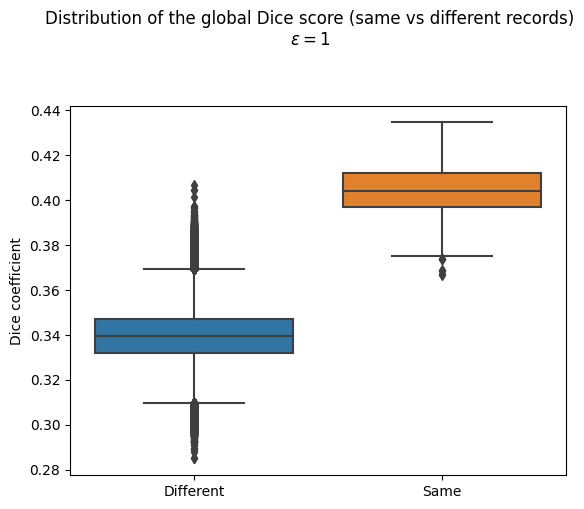

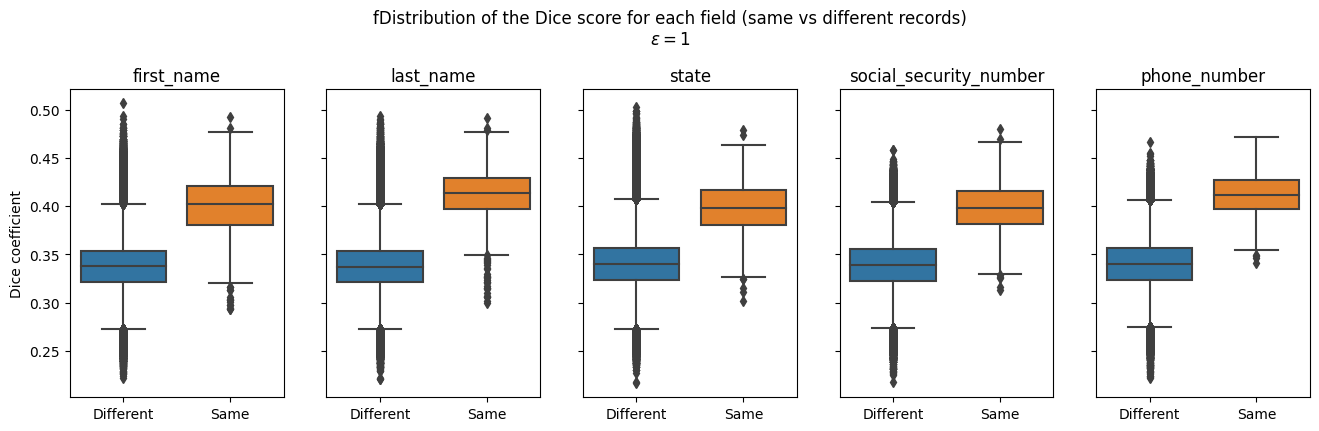

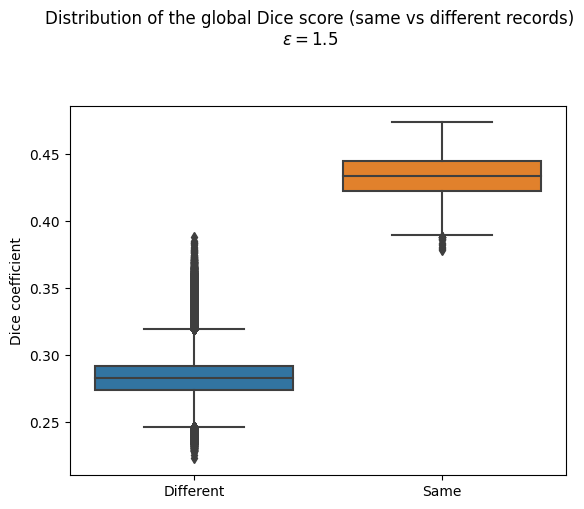

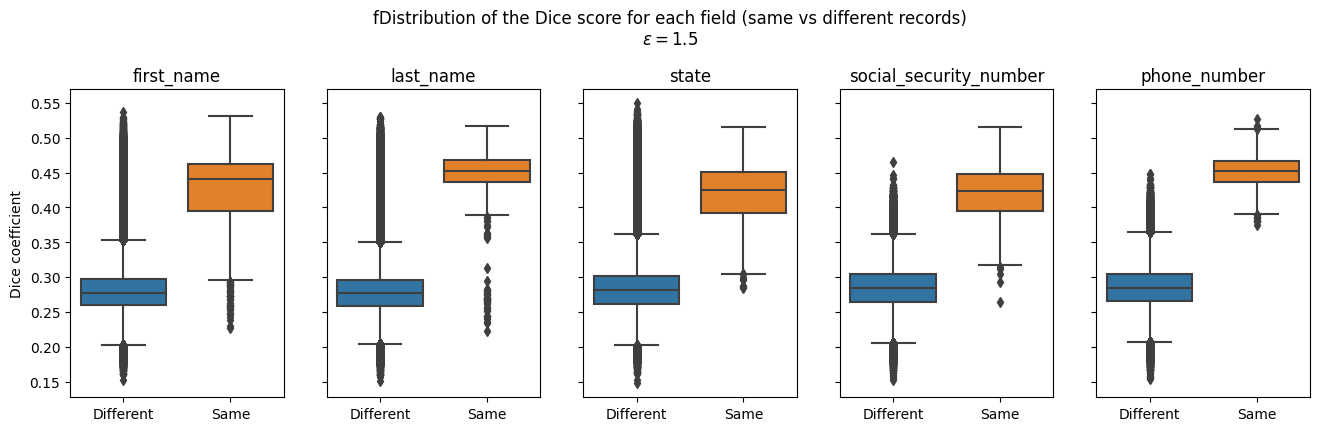

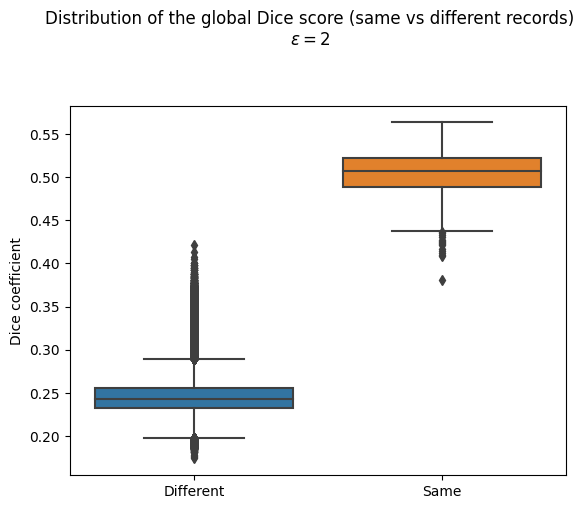

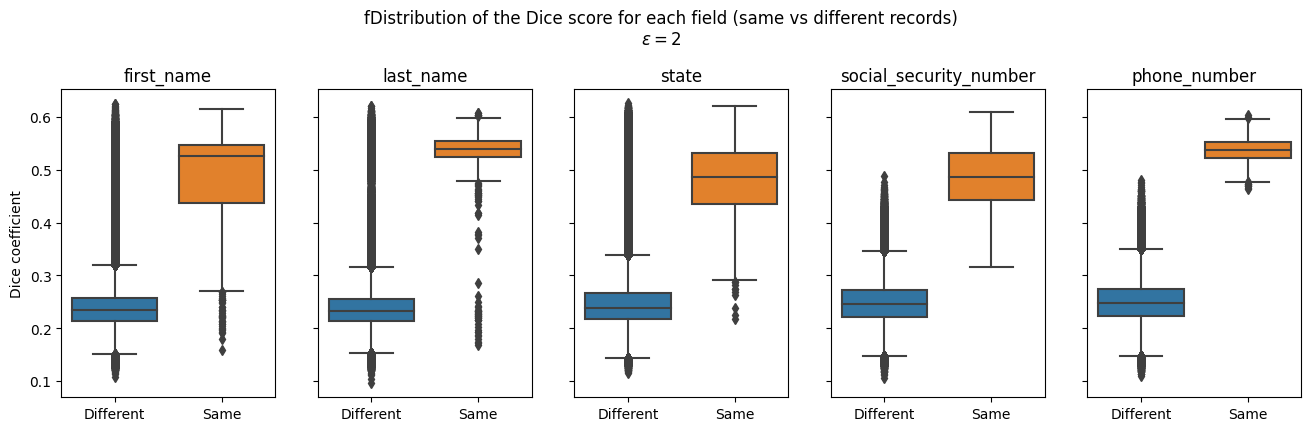

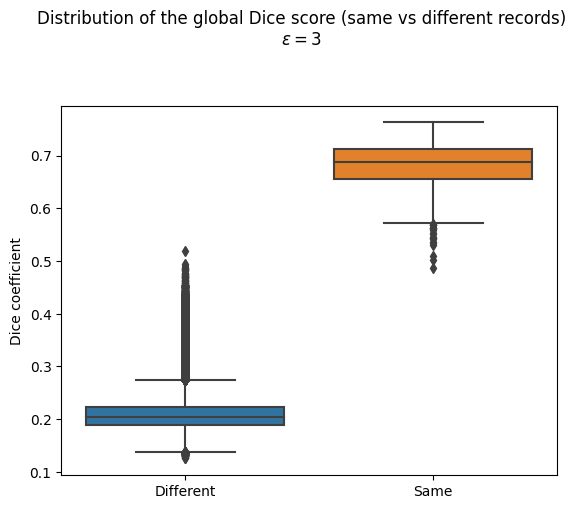

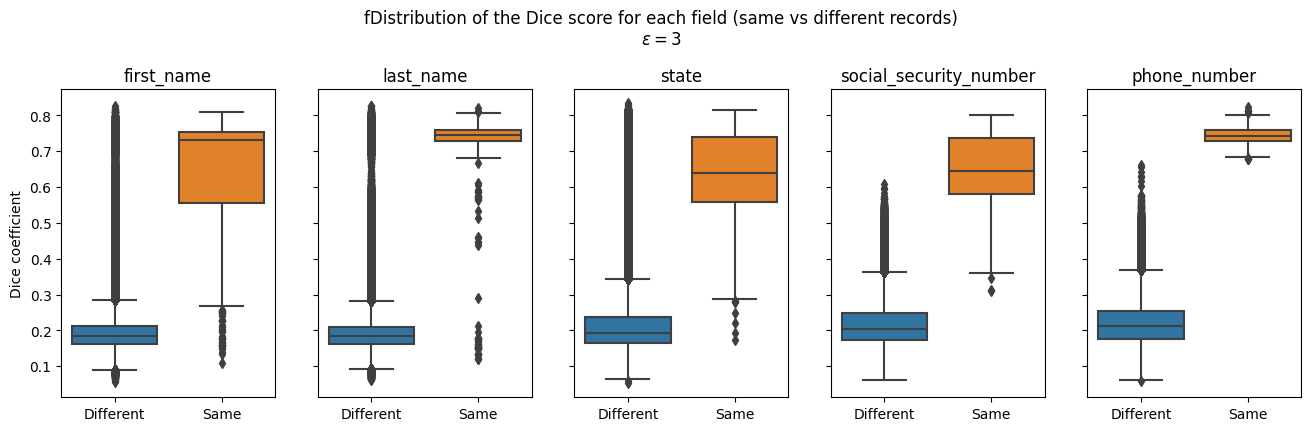

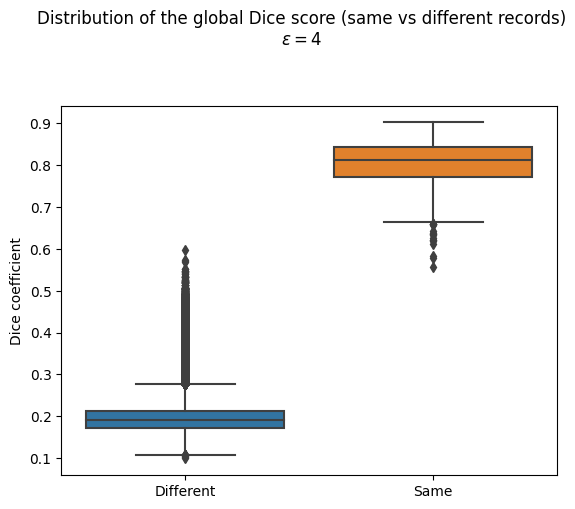

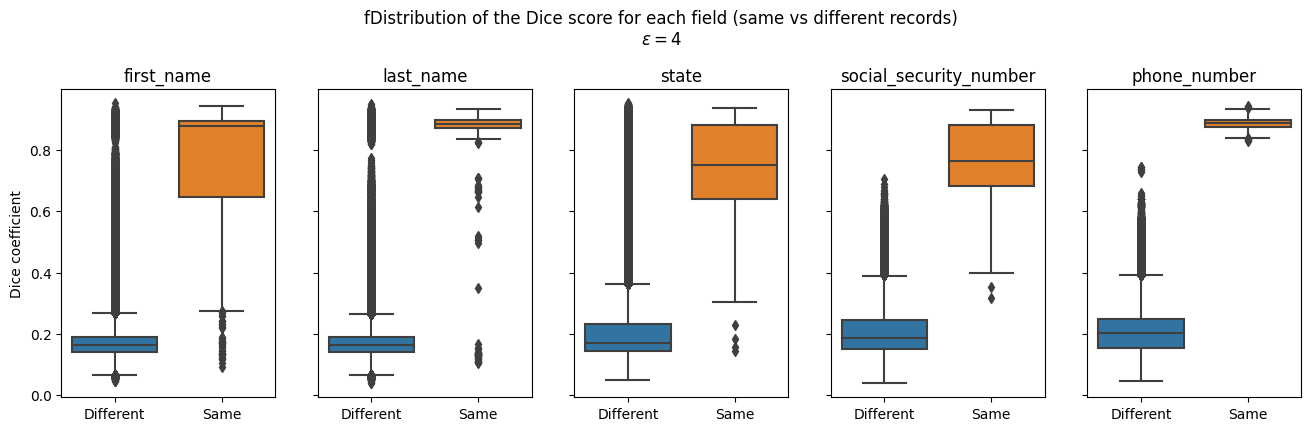

In [40]:
for eps, dices in zip(EPS, dices):
    # Global Dice score distribution
    sns.boxplot(x="same", y="dice", data=dices)
    plt.suptitle(f"Distribution of the global Dice score (same vs different records)\n$\epsilon={eps}$", y=1.08)
    plt.xticks([False, True], labels=["Different", "Same"])
    plt.xlabel("")
    plt.ylabel("Dice coefficient")
    plt.show()

    # Dice score distribution for each field
    fig, axs = plt.subplots(1, len(ALL_FIELDS), sharex=True, sharey=True, figsize=(16, 4))
    for ax, field in zip(axs, ALL_FIELDS):
        sns.boxplot(x="same", y=f"dice_{field}", data=dices, ax=ax)
        ax.set_title(field)
        ax.set_ylabel("")
        ax.set_xticklabels(["Different", "Same"])
        ax.set_xlabel("")
    axs[0].set_ylabel("Dice coefficient")
    fig.suptitle(f"fDistribution of the Dice score for each field (same vs different records)\n$\epsilon={eps}$", y=1.08)
    plt.show()

In [38]:
# Import precision and recall
from sklearn.metrics import precision_score, recall_score

for eps, dices in zip(EPS, dices):
    print(f"eps={eps}")

    THRESHOLD_GLOBAL_DICE = np.mean([
        np.percentile(dices[dices.same].dice, 25),
        np.percentile(dices[~dices.same].dice, 75),
    ])

    # Protocol 1: global Dice score > 0.5
    dices["protocol1"] = dices.dice > 0.4

    # Protocol 2: all but 1 field with Dice score > 0.4
    dices["protocol2"] = (np.array([
        [dices[f"dice_{field}"] > 0.43 for field in ALL_FIELDS]
    ]).sum(axis=1) >= len(ALL_FIELDS) - 1)[0]

    # Protocol 3: all but 2 fields with Dice score > 0.55
    dices["protocol3"] = (np.array([
        [dices[f"dice_{field}"] > 0.4 for field in ALL_FIELDS]
    ]).sum(axis=1) >= len(ALL_FIELDS) - 2)[0]

    # Protocol 4: social security number or phone number with Dice score > 0.65
    dices["protocol4"] = (dices.dice_social_security_number > 0.7) | (dices.dice_phone_number > 0.65)

    # Protocol 5: global Dice score > 0.5
    dices["protocol5"] = (dices.dice > 0.35) & (np.array([
        [dices[f"dice_{field}"] > 0.4 for field in ALL_FIELDS]
    ]).sum(axis=1) >= len(ALL_FIELDS) - 2)[0]

    # Comparison of the protocols

    comparison = pd.DataFrame.from_records([
        {
            "Protocol": f"Protocol {i}",
            "Precision": precision_score(dices.same, dices[f"protocol{i}"]),
            "Recall": recall_score(dices.same, dices[f"protocol{i}"]),
        } for i in range(1, 6)
    ], index="Protocol".split())
    print(comparison)


/home/victor/curesdev/linkage/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall
Protocol,,
Protocol 1,0.996528,0.640625
Protocol 2,1.000000,0.008929
Protocol 3,0.972881,0.640625
Protocol 4,0.000000,0.000000
Protocol 5,0.972881,0.640625


In [13]:
dices[(dices.dice > 0.5) & (dices.same == False)]

,id1,id2,dice,same,dice_first_name,dice_last_name,dice_state,dice_social_security_number,dice_phone_number,protocol1,protocol2,protocol3,protocol4,protocol5
50131,rec-013-org,rec-250-dup-1,0.536697,False,0.597183,0.731844,0.790698,0.349570,0.201183,False,False,True,False,True
50132,rec-013-org,rec-250-org,0.507754,False,0.472222,0.778409,0.771014,0.312139,0.195266,False,False,False,False,True
